Progetto Data Analytics - attività 2

Il progetto si suddivide nelle seguenti parti:

* Introduzione e descrizione generale del Dataset
* Esplorazione del dataset
* Analisi della stazionarietà
* Previsione delle temperature medie mensili del Bangladesh degli ultimi due anni del periodo 2000-2011
* Conclusione

# **Introduzione**

Il dataset utilizzato per l'analisi è Weather Timeseries Data in Bangladesh, disponibile su Kaggle al link https://www.kaggle.com/datasets/farukalam/weather-timeseries-data-in-sylhet-bangladesh.

Il dataset presenta 12113 righe e 7 colonne. Ogni riga contiene il numero del giorno (da 1 a 365 o 366) e l'anno in cui sono state effettuate delle misurazioni sulle condizioni metereologiche in Bangladesh, oltre a dei dati giornalieri medi sulla velocità del vento, l'umidità specifica, l'umidità relativa, le precipitazioni e la temperatura.

In particolare, ho deciso di concentrarmi sulle temperature medie giornaliere del periodo 2000-2011.

Carico il dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('weather_data.csv',encoding='latin-1')
df = df[['Year', 'Day', 'Temperature']]
df

,Year,Day,Temperature
0,1990,1,16.33
1,1990,2,15.68
2,1990,3,16.56
3,1990,4,17.09
4,1990,5,17.26
...,...,...,...
12108,2023,56,24.52
12109,2023,57,24.62
12110,2023,58,24.28
12111,2023,59,23.97


Nel dataset sono presenti due colonne, una relativa all'anno e l'altra al giorno in cui è stata calcolata la temperatura media. Creo un'unica colonna contenente la data nel formato anno-mese-giorno.

In [2]:
def create_date(row):
  return pd.to_datetime(f"{int(row['Year'])}-01-01") + pd.Timedelta(days=row['Day']-1)

df['Date'] = df.apply(create_date, axis=1)
df = df[(df['Date']>='2000-01-01')&(df['Date']<='2011-12-31')]
df = df.drop(['Year', 'Day'], axis=1)
df = df.reset_index(drop=True)
df

,Temperature,Date
0,17.19,2000-01-01
1,16.74,2000-01-02
2,16.58,2000-01-03
3,16.76,2000-01-04
4,16.94,2000-01-05
...,...,...
4378,19.62,2011-12-27
4379,19.91,2011-12-28
4380,20.17,2011-12-29
4381,19.44,2011-12-30


# **Esplorazione del dataset**

Visualizzo la serie temporale nell'arco di tempo selezionato.

<Axes: xlabel='Date'>

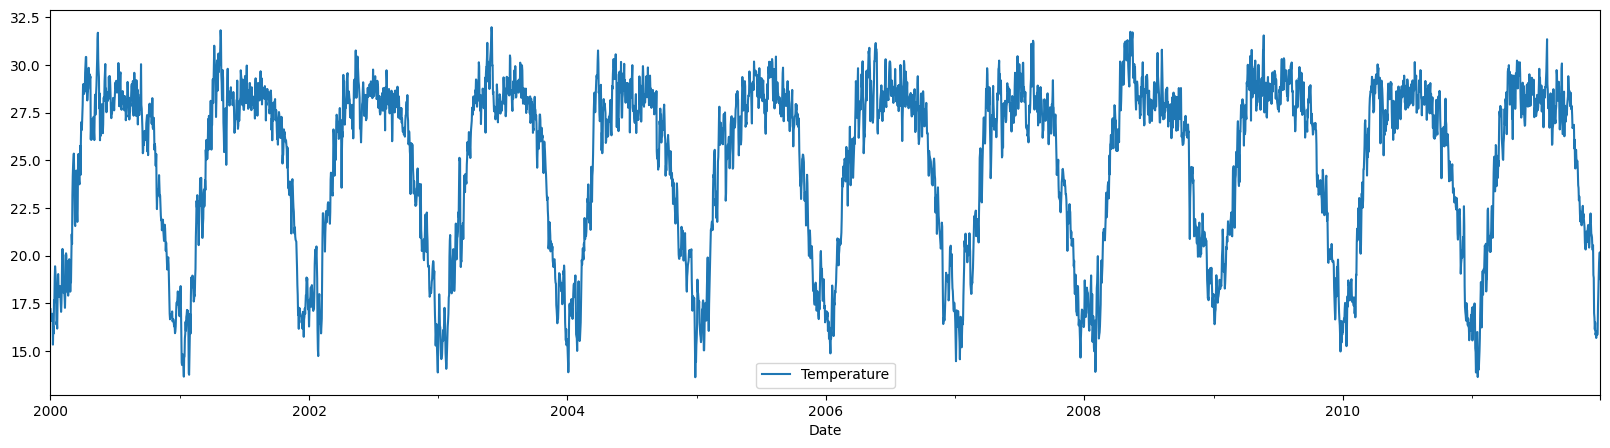

In [3]:
df.plot(x='Date', y='Temperature', figsize=(20,5))

La serie risulta avere una stagionalità annuale e una struttura additiva.

Verifico la presenza di eventuali NaN.

In [4]:
df.isna().sum()

,0
Temperature,0
Date,0


Visualizzo il trend della serie.

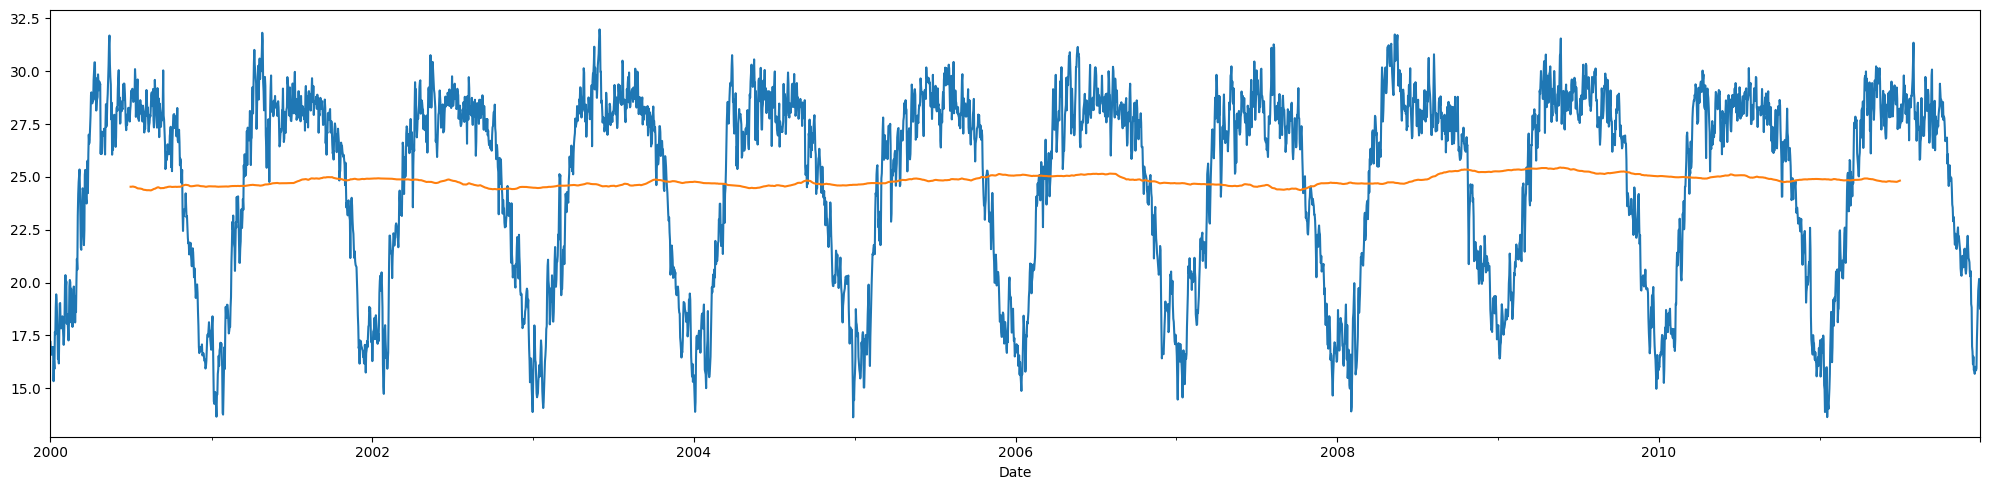

In [5]:
df0 = df.copy()
df0.set_index('Date',inplace=True)
df0['Temperature'].plot()
df0['Temperature'].rolling(365, center=True).mean().plot(figsize=(20,5))
plt.tight_layout()
plt.show()

Come è possibile vedere dal grafico, il trend risulta essere costante.

# **Analisi della stazionarietà**

Per rendere stazionaria la serie temporale è necessario rimuovere la stagionalità, il trend e il rumore. D'altronde, in questo caso, il trend non va rimosso in quanto costante e il rumore non va regolarizzato in quanto additivo.

Per rimuovere la stagionalità, invece, effettuo un subsampling della serie: per ogni mese considero la temperatura media in modo tale da avere 144 misurazioni (12 per ciascuno dei 12 anni considerati).

In particolare, per fare il campionamento tramite la funzione 'resample', indicizzo la serie con le date delle misurazioni.


In [6]:
df.set_index('Date', inplace=True)
df_monthly_mean = df.resample('M').mean()
df_monthly_mean

,Temperature
Date,
2000-01-31,17.497419
2000-02-29,18.894828
2000-03-31,24.150645
2000-04-30,28.576333
2000-05-31,28.093226
...,...
2011-08-31,27.887097
2011-09-30,27.776667
2011-10-31,26.401613


Plotto la nuova serie temporale con anche il trend.

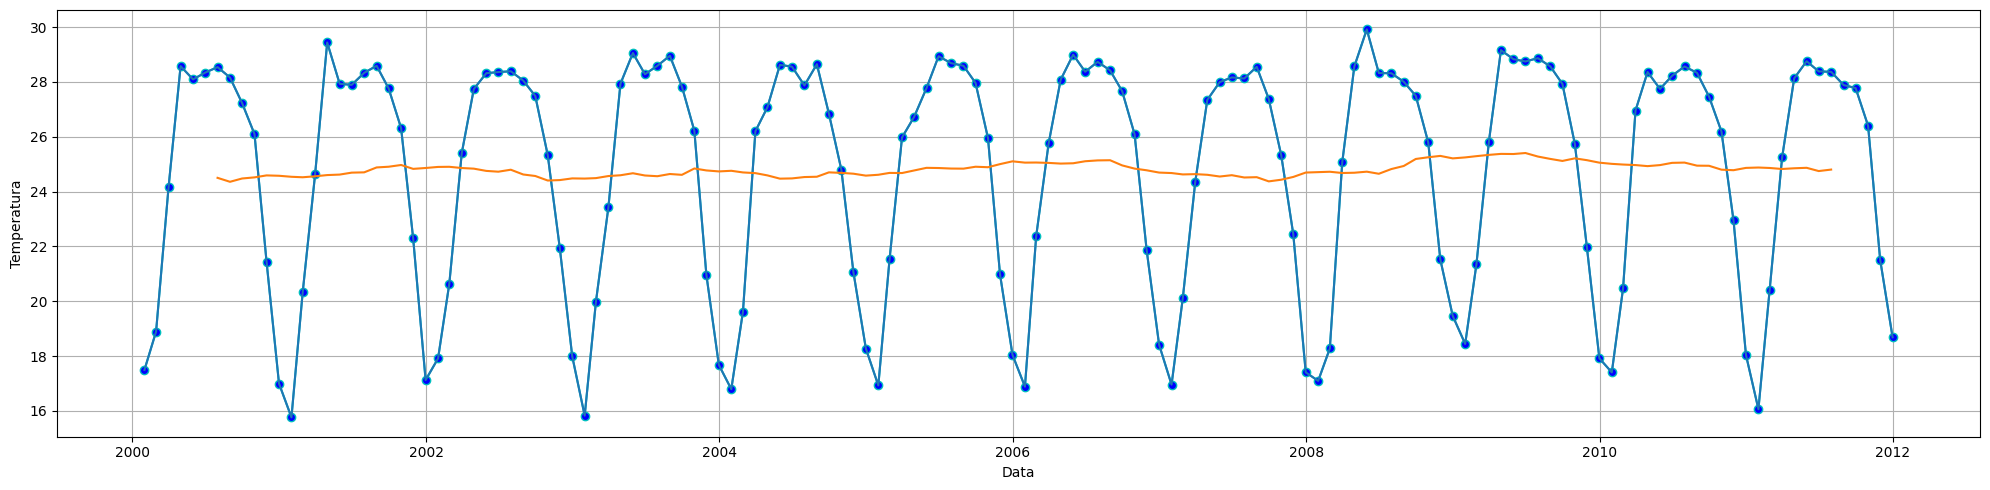

In [7]:
plt.figure(figsize=(20, 5))

plt.plot(df_monthly_mean.index, df_monthly_mean['Temperature'], color='c', marker='o', markerfacecolor='b', linestyle='-')

df0 = df_monthly_mean.copy()

plt.plot(df0.index, df0['Temperature'])
plt.plot(df0.index, df0['Temperature'].rolling(12, center=True).mean())

plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.grid(True)

plt.tight_layout()

plt.show()

Proseguo con la rimozione della stagionalità dalla serie temporale sotto-campionata tramite Lag-12 Differencing,

In più, effettuo l'Augmented Dickey Fuller Test (ADF) per verificare che effettivamente la serie destagionalizzata sia stazionaria.

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

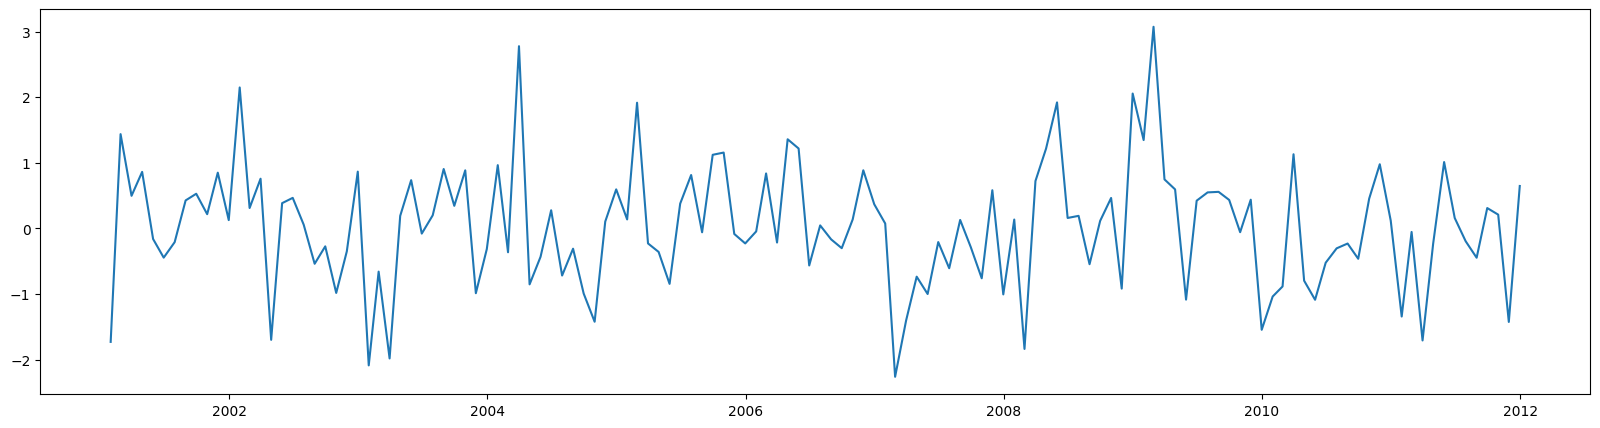


ADF Statistic:  -4.2766226492528245
P-Value:  0.00048749201388223327
Critical Values:
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [9]:
df_monthly_mean['diff12_Temperature']=df_monthly_mean['Temperature'].diff(12)
plt.figure(figsize=(20, 5))
plt.plot(df_monthly_mean['diff12_Temperature'])
plt.show()

print()
adf_test(df_monthly_mean['diff12_Temperature'].dropna())

Il valore ADF Statistic ottenuto risulta essere più piccolo dei valori critici. Dunque, poiché il test è significativo essendo il p-value più piccolo di 0.05, si può concludere che la serie è stazionaria.

Per identificare e visualizzare la presenza di autocorrelazione nella serie temporale considero l'Autocorrelation Function (ACF), strumento grafico utilizzato per anallizzare la correlazione tra la serie temporale e i suoi valori ritardati.

Se i valori di autocorrelazione cadono al di fuori della zona colorata, allora vi è una correlazione significativa a quei lag specifici.

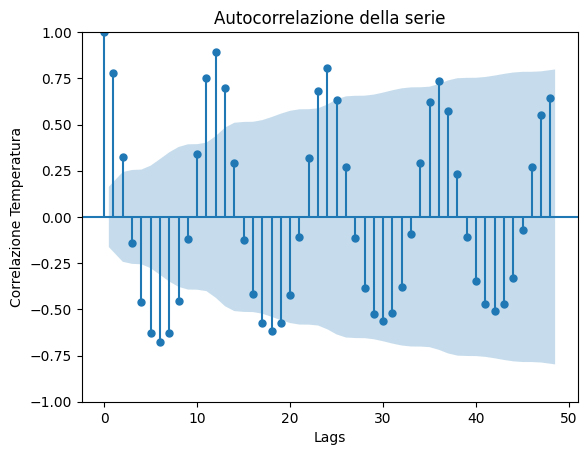

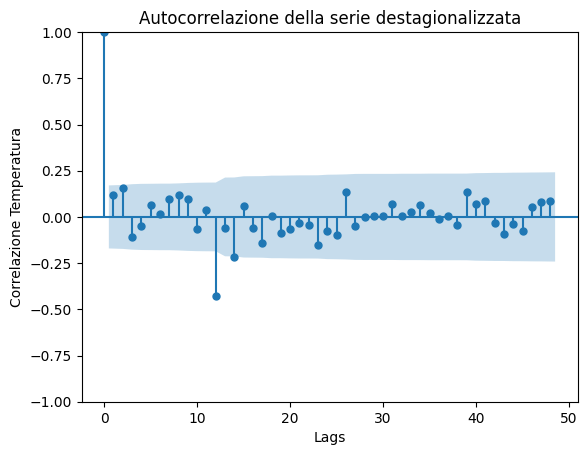

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_monthly_mean['Temperature'].dropna(),lags=48)
plt.ylabel('Correlazione Temperatura')
plt.xlabel('Lags')
plt.title('Autocorrelazione della serie')
plt.show()

plot_acf(df_monthly_mean['diff12_Temperature'].dropna(),lags=48)
plt.ylabel('Correlazione Temperatura')
plt.xlabel('Lags')
plt.title('Autocorrelazione della serie destagionalizzata')
plt.show()

Il primo grafico, ovvero il correlogramma della serie originale, mette in evidenza la stagionalità annuale della serie e presenta elevati valori di autocorrelazione. Invece, nel secondo grafico sono presenti valori inferiori di autocorrelazione e non è più individuabile alcuna stagionalità.

Eseguiamo adesso il test di Ljung-Box per verificare la presenza di valori di autocorrelazione significativi.

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox

print('Ljung-Box serie originale')
print(acorr_ljungbox(df_monthly_mean['Temperature'], return_df=True))
print()

print('Ljung-Box serie destagionalizzata')
print(acorr_ljungbox(df_monthly_mean['diff12_Temperature'].dropna(), return_df=True))

Ljung-Box serie originale
       lb_stat     lb_pvalue
1    89.052783  3.844176e-21
2   104.528538  2.004086e-23
3   107.493148  3.799927e-23
4   139.542793  3.536105e-29
5   198.999234  4.650418e-41
6   268.253172  5.129077e-55
7   328.600871  4.670530e-67
8   360.910719  4.240636e-73
9   363.162236  9.768569e-73
10  381.445213  8.332548e-76

Ljung-Box serie destagionalizzata
      lb_stat  lb_pvalue
1    1.967126   0.160753
2    5.226698   0.073289
3    6.857692   0.076575
4    7.206155   0.125387
5    7.745564   0.170827
6    7.789481   0.253936
7    9.051820   0.248957
8   11.110815   0.195499
9   12.395992   0.191894
10  12.975514   0.225044


Nel test di Ljung-Box, l'ipotesi nulla consiste nel supporre che la serie temporale non presenta autocorrelazione fino al lag specificato.

Per la serie originale si ottengono valori di p-value molto piccoli, dunque si può rifiutare l'ipotesi nulla. Questo permette di dire che sono presenti autocorrelazioni significative nella serie temporale e, in effetti, lb_stat cresce all'aumentare del numero di lag, il che suggerisce la presenza di un pattern stagionale.

Invece, per la serie destagionalizzata si ottengono valori di p-value maggiori di 0.05. Questo vuol dire che non si può rifiutare l'ipotesi nulla e che quindi non c'è un'autocorrelazione significativa nella serie temporale. Questo è coerente col fatto che la serie è stata destagionalizzata e, dunque, ora non presenta più una forte dipendenza tra i suoi valori presenti e passati.

# **Previsione**

Applico un modello autoregressivo (AR) per prevedere le temperature medie mensili degli ultimi due anni sulla base sulle temperature degli anni precedenti.

Considero il Partial Autocorrelation Function (PACF) della serie temporale, stavolta dotata di stagionalità per scopi previsionali. La PACF permette di individuare i lag significativi che servono per determinare l'ordine del modello autoregressivo.

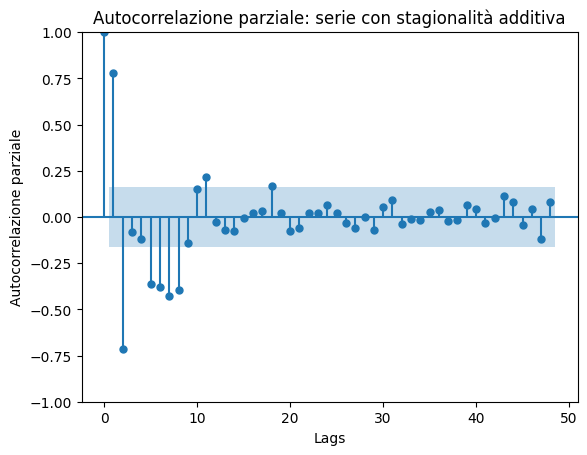

In [12]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_monthly_mean['Temperature'].dropna(),lags=48)
plt.ylabel('Autocorrelazione parziale')
plt.xlabel('Lags')
plt.title('Autocorrelazione parziale: serie con stagionalità additiva')
plt.show()

È possibile notare che soltanto i primi lag risultano essere significativi, il che indica che la serie temporale può essere modellata in modo efficace con un modello AR. In particolare, l'ultimo lag che esce dalla bande di confidenza è l'undicesimo, parametro che verrà passato come maxlag=11 nella funzione ar_select_order.

Divido il dataset in training set e test set. Il primo contiene le misurazioni mensili dei primi dieci anni, mentre il secondo quelle degli ultimi due.


In [13]:
train = df_monthly_mean.iloc[:-24].copy()
test = df_monthly_mean.iloc[-24:].copy()

selector = ar_select_order(train['Temperature'].dropna(), maxlag=11, seasonal=True, period=12)
model = AutoReg(train['Temperature'].dropna(), lags=selector.ar_lags, seasonal=True, period=12).fit()

Plotto l'andamento dei valori previsti, il MAE e il MAE relativo e verifico che i residui della previsione non siano autocorrelati tramite il test di Ljung-Box.

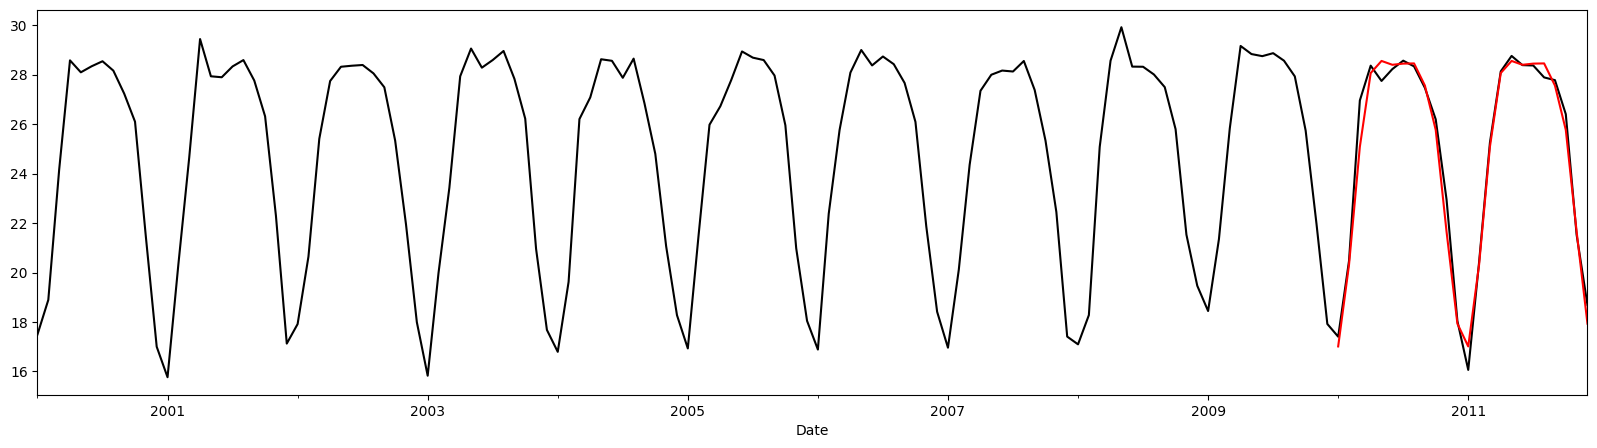


L'errore assoluto medio (MAE) dell'autoregressione è 0.40569064679449457.
L'errore assoluto medio relativo dell'autoregressione è 1.63%



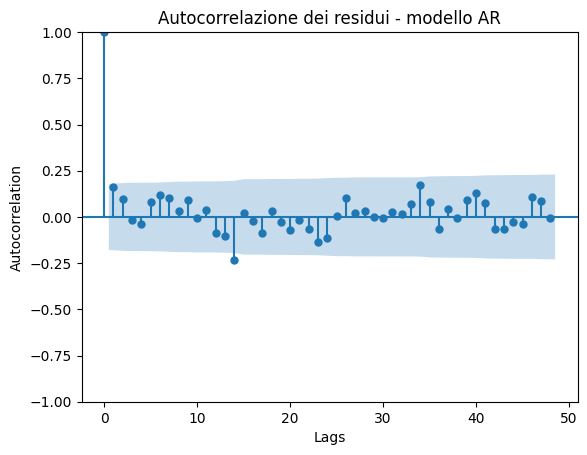


     lb_stat  lb_pvalue
1   3.235764   0.072047
2   4.347055   0.113776
3   4.393826   0.221959
4   4.559475   0.335553
5   5.406707   0.368284
6   7.138714   0.308209
7   8.537486   0.287589
8   8.676294   0.370335
9   9.789036   0.367833
10  9.792283   0.458902
11  9.977545   0.532408


In [14]:
forecasts = model.forecast(steps=len(test))
test['forecasts'] = forecasts
plt.figure(figsize=(20, 5))
df_monthly_mean['Temperature'].plot(color='k')
test['forecasts'].plot(color='red')
plt.show()

print()
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test['Temperature'], test['forecasts'])
print(f"L'errore assoluto medio (MAE) dell'autoregressione è {MAE}.")
mean_actual = np.mean(test['Temperature'])
relative_mae = MAE / mean_actual
print(f"L'errore assoluto medio relativo dell'autoregressione è {round(relative_mae*100,2)}%")
print()

residuals = (train['Temperature'] - model.fittedvalues).dropna()
plot_acf(residuals,lags=48)
plt.ylabel('Autocorrelation')
plt.xlabel('Lags')
plt.title('Autocorrelazione dei residui - modello AR')
plt.show()

print()
print(acorr_ljungbox(residuals, lags=11, return_df=True))

# **Conclusione**

Tramite l'analisi della serie temporale relativa alle temperature medie del Bangladesh negli anni 2000-2011 e la trasformazione in serie stazionaria, è stato possibile costruire un modello autoregressivo per predire con successo (con una percentuale di errore di solo l'1.63% e con residui del modello AR non autocorrelati) le misurazioni degli ultimi due anni.